<a href="https://colab.research.google.com/github/Gk58IISERTvm98/Image_Classifier-ANN-and-DNN/blob/main/Notebooks/Training_Deep_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default DNN configuration
<font color="blue">

|<font color="red"> Hyperparameter   |<font color="red">Default value  |
|:-----------------|:--------------------|
| Kernel initializer  |  LeCun initialization |
| Activation function | SELU |
| Normalization       | None (self-normalization) |
| Regularization      | Early stopping |
| Optimizer           | Nadam  |
| Learning rate schedule|  Performance scheduling |





* **If your model self-normalizes:**
If it overfits the training set, then you should add alpha dropout (and always
use early stopping as well). Do not use other regularization methods, or else
they would break self-normalization.

* **If your model cannot self-normalize (e.g., it is a recurrent net or it contains skip
connections):**
>* You can try using ELU (or another activation function) instead of SELU, it
may perform better. Make sure to change the initialization method accord‐
ingly (e.g., He init for ELU or ReLU).
>* If it is a deep network, you should use Batch
Normalization after every hidden
layer. If it overfits the training set, you can also try using max-norm or ℓ2 reg‐
ularization.

* If you need a sparse model, you can use ℓ1 regularization (and optionally zero out
the tiny weights after training). If you need an even sparser model, you can try
using FTRL instead of Nadam optimization, along with ℓ1 regularization. In any
case, this will break self-normalization, so you will need to switch to BN if your
model is deep.

* If you need a low-latency model (one that performs lightning-fast predictions),
you may need to use less layers, avoid Batch Normalization, and possibly replace
the SELU activation function with the leaky ReLU. Having a sparse model will
also help. You may also want to reduce the float precision from 32-bits to 16-bit
(or even 8-bits)

* If you are building a risk-sensitive application, or inference latency is not very
important in your application, you can use MC Dropout to boost performance
and get more reliable probability estimates, along with uncertainty estimates.

In [ ]:
import sklearn
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Vanishing/Exploding Gradients Problem

In [ ]:
def logistic(z):
  return 1 / (1 + np.exp(-z))

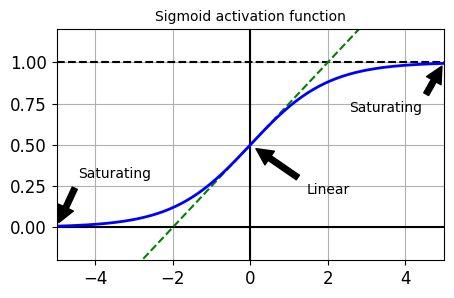

In [ ]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(5,3))
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logistic(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=10, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=10, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=10, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=10)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

# Nonsaturating Activation Functions

**Leaky ReLU**

In [ ]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

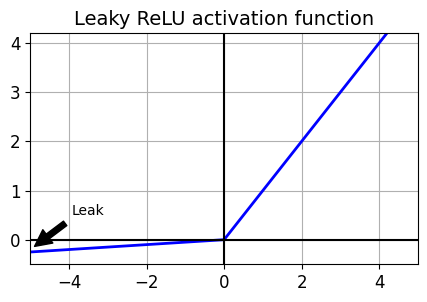

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=10, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

**Let's train a neural network on Fashion MNIST using the Leaky ReLU:**

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4933 - loss: 1.6205 - val_accuracy: 0.7334 - val_loss: 0.8700
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7337 - loss: 0.8283 - val_accuracy: 0.7834 - val_loss: 0.7002
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7764 - loss: 0.6893 - val_accuracy: 0.8046 - val_loss: 0.6249
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7980 - loss: 0.6215 - val_accuracy: 0.8194 - val_loss: 0.5798
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8081 - loss: 0.5800 - val_accuracy: 0.8254 - val_loss: 0.5499
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8164 - loss: 0.5520 - val_accuracy: 0.8304 - val_loss: 0.5283
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8214 - loss: 0.5313 - val_accuracy: 0.8332 - val_loss: 0.5119
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8256 - loss: 0.5152 -

**Now let's try PReLU:**

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4638 - loss: 1.6644 - val_accuracy: 0.7158 - val_loss: 0.9022
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7281 - loss: 0.8561 - val_accuracy: 0.7698 - val_loss: 0.7196
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7736 - loss: 0.7082 - val_accuracy: 0.7920 - val_loss: 0.6379
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7919 - loss: 0.6356 - val_accuracy: 0.8068 - val_loss: 0.5892
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8055 - loss: 0.5903 - val_accuracy: 0.8184 - val_loss: 0.5563
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8134 - loss: 0.5589 - val_accuracy: 0.8250 - val_loss: 0.5324
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8208 - loss: 0.5356 - val_accuracy: 0.8296 - val_loss: 0.5139
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8258 - loss: 0.51

# ELU

In [ ]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

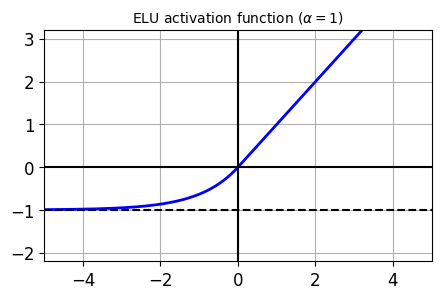

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=10)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

# SELU
This activation function outperforms the other activation functions very significantly for such neural nets. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ1 or ℓ2 regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [ ]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [ ]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

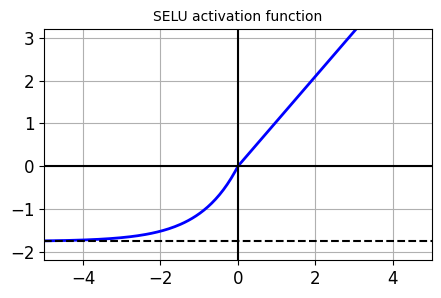

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=10)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [ ]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [ ]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

<Dense name=dense_6, built=False>

**Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 45s 23ms/step - accuracy: 0.4338 - loss: 1.4873 - val_accuracy: 0.7232 - val_loss: 0.7608
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.7326 - loss: 0.7102 - val_accuracy: 0.7508 - val_loss: 0.6551
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - accuracy: 0.7754 - loss: 0.6054 - val_accuracy: 0.7896 - val_loss: 0.5618
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.8022 - loss: 0.5412 - val_accuracy: 0.8044 - val_loss: 0.5370
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.8178 - loss: 0.5041 - val_accuracy: 0.8224 - val_loss: 0.4922


**Now look at what happens if we try to use the ReLU activation function instead:**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - accuracy: 0.1613 - loss: 2.1746 - val_accuracy: 0.3118 - val_loss: 1.6608
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.3742 - loss: 1.6079 - val_accuracy: 0.3998 - val_loss: 1.4557
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.4405 - loss: 1.4045 - val_accuracy: 0.5002 - val_loss: 1.2428
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.4639 - loss: 1.3484 - val_accuracy: 0.5478 - val_loss: 1.2043
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.5203 - loss: 1.1906 - val_accuracy: 0.6458 - val_loss: 0.9320


Not great at all, we suffered from the vanishing/exploding gradients problem.

# GELU, Swish and Mish

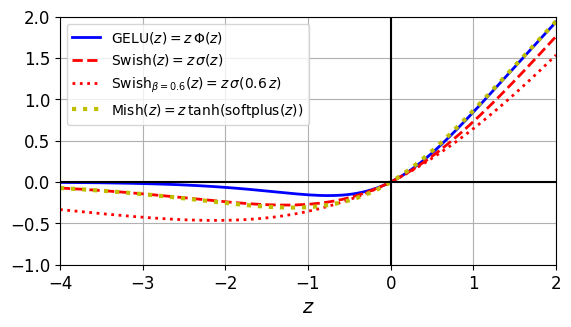

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "y:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")
plt.show()

# Batch Normalization

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 784)                 │           3,136 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 300)                 │           1,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 271,346 (1.04 MB)

 Trainable params: 268,978 (1.03 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [ ]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('gamma', True),
 ('beta', True),
 ('moving_mean', False),
 ('moving_variance', False)]

In [ ]:
# extra code – just show that the model works!
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.6015 - loss: 1.2052 - val_accuracy: 0.8170 - val_loss: 0.5411
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.8009 - loss: 0.5851 - val_accuracy: 0.8402 - val_loss: 0.4689
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.8246 - loss: 0.5114 - val_accuracy: 0.8516 - val_loss: 0.4358
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8393 - loss: 0.4719 - val_accuracy: 0.8580 - val_loss: 0.4155
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8473 - loss: 0.4451 - val_accuracy: 0.8624 - val_loss: 0.4010
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8537 - loss: 0.4248 - val_accuracy: 0.8634 - val_loss: 0.3898
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8585 - loss: 0.4083 - val_accuracy: 0.8658 - val_loss: 0.3810
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8632 - loss: 

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a BatchNormalization layer does not need to have bias terms, since the BatchNormalization layer has some as well, it would be a waste of parameters, so you can set **use_bias=False** when creating those layers:

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.5759 - loss: 1.3302 - val_accuracy: 0.7874 - val_loss: 0.6636
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.7727 - loss: 0.7028 - val_accuracy: 0.8204 - val_loss: 0.5516
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8031 - loss: 0.6012 - val_accuracy: 0.8352 - val_loss: 0.4992
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.8183 - loss: 0.5477 - val_accuracy: 0.8444 - val_loss: 0.4679
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8272 - loss: 0.5133 - val_accuracy: 0.8480 - val_loss: 0.4466
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8344 - loss: 0.4884 - val_accuracy: 0.8522 - val_loss: 0.4307
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8409 - loss: 0.4691 - val_accuracy: 0.8560 - val_loss: 0.4184
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8455 - loss: 0

# Gradient Clipping
Another popular technique to lessen the exploding gradients problem is to simply
clip the gradients during backpropagation so that they never exceed some threshold.This technique is most often used in recurrent neural networks, as Batch Normalization is tricky to use in RNNs,

In [ ]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [ ]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

# Reusing Pretrained Layers

**Reusing a Keras model**

Let's split the fashion MNIST training set in two:

**X_train_A:** all images of all items except for sandals and shirts (classes 5 and 6).

**X_train_B:** a much smaller training set of just the first 200 images of sandals or shirts.
The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using Dense layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [ ]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [ ]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [ ]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7334 - loss: 0.8302 - val_accuracy: 0.8565 - val_loss: 0.3960
Epoch 2/20
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8690 - loss: 0.3739 - val_accuracy: 0.8737 - val_loss: 0.3436
Epoch 3/20
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8831 - loss: 0.3305 - val_accuracy: 0.8834 - val_loss: 0.3196
Epoch 4/20
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8902 - loss: 0.3087 - val_accuracy: 0.8921 - val_loss: 0.3053
Epoch 5/20
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8954 - loss: 0.2944 - val_accuracy: 0.8941 - val_loss: 0.2963
Epoch 6/20
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8994 - loss: 0.2834 - val_accuracy: 0.8981 - val_loss: 0.2889
Epoch 7/20
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9027 - loss: 0.2745 - val_accuracy: 0.9003 - val_loss: 0.2820
Epoch 8/20
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9055 - loss: 0.2670 

In [ ]:
model_A.save("my_model_A.h5")

In [ ]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [ ]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4269 - loss: 0.8205 - val_accuracy: 0.6724 - val_loss: 0.6041
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7014 - loss: 0.5495 - val_accuracy: 0.7708 - val_loss: 0.4861
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8131 - loss: 0.4367 - val_accuracy: 0.8418 - val_loss: 0.4066
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8783 - loss: 0.3600 - val_accuracy: 0.8834 - val_loss: 0.3494
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9305 - loss: 0.3047 - val_accuracy: 0.9108 - val_loss: 0.3061
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9610 - loss: 0.2630 - val_accuracy: 0.9300 - val_loss: 0.2726
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9728 - loss: 0.2312 - val_accuracy: 0.9452 - val_loss: 0.2462
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9816 - loss: 0.2062 - val_accuracy: 0.9503 - val_loss: 0.2248


In [ ]:
model_B.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 275,803 (1.05 MB)

 Trainable params: 275,801 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

Note that model_B_on_A and model_A actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build model_B_on_A on top of a clone of model_A:

In [ ]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8333 - loss: 0.4176 - val_accuracy: 0.8286 - val_loss: 0.4068
Epoch 2/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8496 - loss: 0.3976 - val_accuracy: 0.8448 - val_loss: 0.3893
Epoch 3/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8615 - loss: 0.3793 - val_accuracy: 0.8570 - val_loss: 0.3732
Epoch 4/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8792 - loss: 0.3626 - val_accuracy: 0.8671 - val_loss: 0.3584
Epoch 1/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9173 - loss: 0.3253 - val_accuracy: 0.9128 - val_loss: 0.2698
Epoch 2/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9389 - loss: 0.2413 - val_accuracy: 0.9422 - val_loss: 0.2201
Epoch 3/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9571 - loss: 0.1928 - val_accuracy: 0.9594 - val_loss: 0.1873
Epoch 4/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9653 - loss: 0.1606 - val_accuracy: 0.9665 - val_loss: 0.1638
Epoc

In [ ]:
model_B.evaluate(X_test_B, y_test_B)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9810 - loss: 0.1068


[0.11748618632555008, 0.9760000109672546]

In [ ]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0681


[0.06759557873010635, 0.9909999966621399]

# Faster Optimizers


In [ ]:
def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [ ]:
history_sgd = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6718 - loss: 0.9811 - val_accuracy: 0.8388 - val_loss: 0.4750
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8298 - loss: 0.4829 - val_accuracy: 0.8562 - val_loss: 0.4161
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8467 - loss: 0.4310 - val_accuracy: 0.8644 - val_loss: 0.3894
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8579 - loss: 0.4009 - val_accuracy: 0.8678 - val_loss: 0.3748
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8650 - loss: 0.3793 - val_accuracy: 0.8718 - val_loss: 0.3620
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8700 - loss: 0.3630 - val_accuracy: 0.8752 - val_loss: 0.3519
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8736 - loss: 0.3491 - val_accuracy: 0.8782 - val_loss: 0.3458
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8775 - loss: 0.3375 

### **Momentum optimization**

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [ ]:
history_momentum = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6637 - loss: 0.9953 - val_accuracy: 0.8310 - val_loss: 0.4849
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8304 - loss: 0.4781 - val_accuracy: 0.8492 - val_loss: 0.4276
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8479 - loss: 0.4278 - val_accuracy: 0.8584 - val_loss: 0.4049
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8579 - loss: 0.3990 - val_accuracy: 0.8618 - val_loss: 0.3866
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8648 - loss: 0.3787 - val_accuracy: 0.8690 - val_loss: 0.3738
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8704 - loss: 0.3622 - val_accuracy: 0.8730 - val_loss: 0.3614
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8752 - loss: 0.3490 - val_accuracy: 0.8738 - val_loss: 0.3557
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8780 - loss: 0.3376 -

### **Nesterov Accelerated Gradient**

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

In [ ]:
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6686 - loss: 0.9948 - val_accuracy: 0.8294 - val_loss: 0.4759
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8307 - loss: 0.4806 - val_accuracy: 0.8498 - val_loss: 0.4197
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8485 - loss: 0.4285 - val_accuracy: 0.8592 - val_loss: 0.3914
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8578 - loss: 0.3988 - val_accuracy: 0.8684 - val_loss: 0.3714
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8646 - loss: 0.3781 - val_accuracy: 0.8704 - val_loss: 0.3592
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8695 - loss: 0.3617 - val_accuracy: 0.8752 - val_loss: 0.3488
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8734 - loss: 0.3480 - val_accuracy: 0.8780 - val_loss: 0.3426
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8775 - loss: 0.336

### **AdaGrad**

In [ ]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

In [ ]:
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5217 - loss: 1.4308 - val_accuracy: 0.7748 - val_loss: 0.6794
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7801 - loss: 0.6652 - val_accuracy: 0.8038 - val_loss: 0.5898
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8035 - loss: 0.5893 - val_accuracy: 0.8146 - val_loss: 0.5507
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8148 - loss: 0.5522 - val_accuracy: 0.8222 - val_loss: 0.5266
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8217 - loss: 0.5283 - val_accuracy: 0.8270 - val_loss: 0.5094
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8270 - loss: 0.5109 - val_accuracy: 0.8308 - val_loss: 0.4963
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8314 - loss: 0.4974 - val_accuracy: 0.8344 - val_loss: 0.4858
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8349 - loss: 0.4864 -

### **RMSProp**

In [ ]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [ ]:
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7642 - loss: 0.6541 - val_accuracy: 0.7948 - val_loss: 0.5505
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8528 - loss: 0.4059 - val_accuracy: 0.8560 - val_loss: 0.4061
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8660 - loss: 0.3716 - val_accuracy: 0.8322 - val_loss: 0.5005
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8725 - loss: 0.3588 - val_accuracy: 0.8268 - val_loss: 0.5160
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8784 - loss: 0.3507 - val_accuracy: 0.8344 - val_loss: 0.5027
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8810 - loss: 0.3434 - val_accuracy: 0.8568 - val_loss: 0.4693
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8810 - loss: 0.3394 - val_accuracy: 0.8222 - val_loss: 0.5625
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8825 - loss: 0.335

### **Adam Optimization**

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [ ]:
history_adam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7716 - loss: 0.6441 - val_accuracy: 0.8686 - val_loss: 0.3586
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8551 - loss: 0.3869 - val_accuracy: 0.8734 - val_loss: 0.3429
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8711 - loss: 0.3460 - val_accuracy: 0.8814 - val_loss: 0.3274
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8822 - loss: 0.3168 - val_accuracy: 0.8764 - val_loss: 0.3389
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8894 - loss: 0.2955 - val_accuracy: 0.8748 - val_loss: 0.3394
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8934 - loss: 0.2821 - val_accuracy: 0.8800 - val_loss: 0.3319
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8997 - loss: 0.2673 - val_accuracy: 0.8802 - val_loss: 0.3455
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9025 - loss: 0.2570

### **Adamax Optimization**

In [ ]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [ ]:
history_adamax = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7645 - loss: 0.7051 - val_accuracy: 0.8656 - val_loss: 0.3993
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8532 - loss: 0.4077 - val_accuracy: 0.8724 - val_loss: 0.3666
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8668 - loss: 0.3650 - val_accuracy: 0.8776 - val_loss: 0.3460
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8760 - loss: 0.3391 - val_accuracy: 0.8804 - val_loss: 0.3354
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8828 - loss: 0.3194 - val_accuracy: 0.8818 - val_loss: 0.3272
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8890 - loss: 0.3027 - val_accuracy: 0.8838 - val_loss: 0.3187
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8940 - loss: 0.2893 - val_accuracy: 0.8860 - val_loss: 0.3138
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8985 - loss: 0.278

### **Nadam Optimization**

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [ ]:
history_nadam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7782 - loss: 0.6209 - val_accuracy: 0.8674 - val_loss: 0.3673
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8623 - loss: 0.3760 - val_accuracy: 0.8792 - val_loss: 0.3340
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8746 - loss: 0.3387 - val_accuracy: 0.8804 - val_loss: 0.3373
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8828 - loss: 0.3156 - val_accuracy: 0.8808 - val_loss: 0.3203
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8899 - loss: 0.2948 - val_accuracy: 0.8814 - val_loss: 0.3296
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8965 - loss: 0.2793 - val_accuracy: 0.8852 - val_loss: 0.3195
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8995 - loss: 0.2651 - val_accuracy: 0.8884 - val_loss: 0.3180
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9037 - loss: 0.2558

### **AdamW Optimization**

In [ ]:
optimizer = tf.keras.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                      beta_1=0.9, beta_2=0.999)

In [ ]:
history_adamw = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7677 - loss: 0.6484 - val_accuracy: 0.8620 - val_loss: 0.3756
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8553 - loss: 0.3915 - val_accuracy: 0.8658 - val_loss: 0.3750
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8696 - loss: 0.3526 - val_accuracy: 0.8684 - val_loss: 0.3588
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8809 - loss: 0.3239 - val_accuracy: 0.8792 - val_loss: 0.3430
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8869 - loss: 0.3042 - val_accuracy: 0.8804 - val_loss: 0.3325
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8937 - loss: 0.2874 - val_accuracy: 0.8818 - val_loss: 0.3375
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8964 - loss: 0.2755 - val_accuracy: 0.8842 - val_loss: 0.3322
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9017 - loss: 0.26

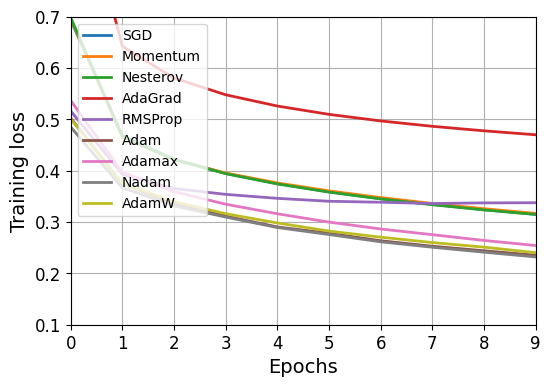

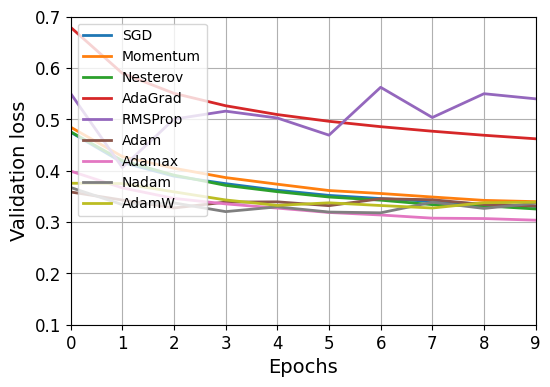

In [ ]:
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(6, 4))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=2)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

# Learning Rate Scheduling

**Power Scheduling**

This schedule first drops quickly, then more and more
slowly.

lr = lr / (1 + steps / s)**c

Keras uses c=1 and s = 1 / decay

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [ ]:
# RECOMMENDED:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7874 - loss: 0.6092 - val_accuracy: 0.8612 - val_loss: 0.4100
Epoch 2/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8618 - loss: 0.3876 - val_accuracy: 0.8678 - val_loss: 0.3802
Epoch 3/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8754 - loss: 0.3515 - val_accuracy: 0.8736 - val_loss: 0.3656
Epoch 4/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8843 - loss: 0.3289 - val_accuracy: 0.8770 - val_loss: 0.3569
Epoch 5/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8897 - loss: 0.3126 - val_accuracy: 0.8798 - val_loss: 0.3508
Epoch 6/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8938 - loss: 0.2997 - val_accuracy: 0.8808 - val_loss: 0.3462
Epoch 7/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8978 - loss: 0.2891 - val_accuracy: 0.8826 - val_loss: 0.3428
Epoch 8/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9009 - loss: 0.280

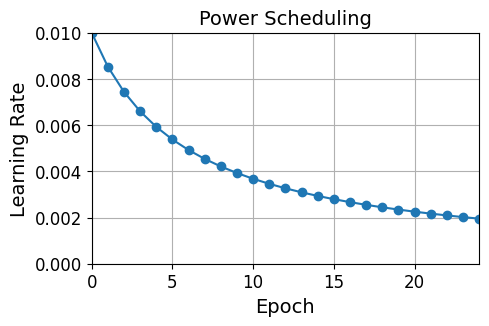

In [ ]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.figure(figsize=(5, 3))
plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

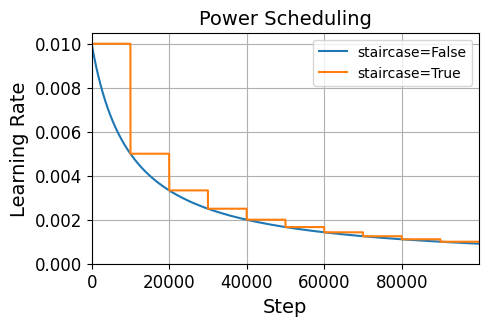

In [ ]:
# extra code – this cell plots power scheduling with staircase=True or False

initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * steps / decay_steps)
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

plt.figure(figsize=(5, 3))
plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### **Exponential Scheduling**

lr = lro * 0.1**(epoch / s)

$ learning\_rate = initial\_learning\_rate * decay\_rate ^ {(step / decay\_steps)}$

The learning rate will gradually drop by a
factor of 10 every s steps. While power scheduling reduces the learning rate more
and more slowly, exponential scheduling keeps slashing it by a factor of 10 every
s steps.

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [ ]:
history_exponential_scheduling = build_and_train_model(optimizer)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6546 - loss: 1.0482 - val_accuracy: 0.8174 - val_loss: 0.5294
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8239 - loss: 0.4950 - val_accuracy: 0.8448 - val_loss: 0.4505
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8446 - loss: 0.4417 - val_accuracy: 0.8544 - val_loss: 0.4168
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8550 - loss: 0.4131 - val_accuracy: 0.8612 - val_loss: 0.3982
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8607 - loss: 0.3945 - val_accuracy: 0.8664 - val_loss: 0.3870
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8645 - loss: 0.3815 - val_accuracy: 0.8690 - val_loss: 0.3799
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8676 - loss: 0.3719 - val_accuracy: 0.8708 - val_loss: 0.3744
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8707 - loss: 0.3645 - 

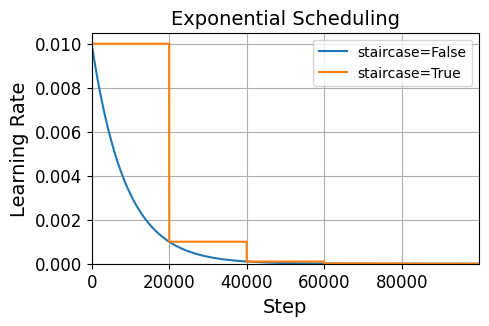

In [ ]:
initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.figure(figsize=(5, 3))
plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Keras also provides a LearningRateScheduler callback class that lets you define your own scheduling function. Let's see how you could use it to implement exponential decay. Note that in this case the learning rate only changes at each epoch, not at each step

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7572 - loss: 1.0016 - val_accuracy: 0.8018 - val_loss: 0.7225 - learning_rate: 0.0100
Epoch 2/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8019 - loss: 0.6419 - val_accuracy: 0.8042 - val_loss: 0.7560 - learning_rate: 0.0089
Epoch 3/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.8168 - loss: 0.5972 - val_accuracy: 0.8326 - val_loss: 0.6031 - learning_rate: 0.0079
Epoch 4/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8265 - loss: 0.5592 - val_accuracy: 0.8436 - val_loss: 0.5620 - learning_rate: 0.0071
Epoch 5/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8457 - loss: 0.4909 - val_accuracy: 0.8390 - val_loss: 0.6548 - learning_rate: 0.0063
Epoch 6/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8463 - loss: 0.4932 - val_accuracy: 0.8592 - val_loss: 0.5496 - learning_rate: 0.0056
Epoch 7/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8

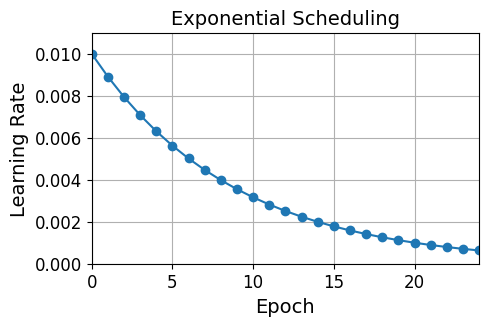

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(history.epoch, history.history['learning_rate'], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [ ]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [ ]:
K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Input(shape=[28, 28]),  # Explicit Input layer
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


In [ ]:
import math

n_epochs = 25
batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25


AttributeError: 'str' object has no attribute 'name'

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[])

In [ ]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

In [ ]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

**Piecewise Constant Scheduling**

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000],
    values=[0.01, 0.005, 0.001]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [ ]:
history_piecewise_scheduling = build_and_train_model(optimizer)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6781 - loss: 0.9530 - val_accuracy: 0.8144 - val_loss: 0.5235
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8291 - loss: 0.4828 - val_accuracy: 0.8444 - val_loss: 0.4484
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8476 - loss: 0.4276 - val_accuracy: 0.8616 - val_loss: 0.4101
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8587 - loss: 0.3964 - val_accuracy: 0.8634 - val_loss: 0.3914
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8656 - loss: 0.3755 - val_accuracy: 0.8664 - val_loss: 0.3758
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8704 - loss: 0.3590 - val_accuracy: 0.8700 - val_loss: 0.3649
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8744 - loss: 0.3458 - val_accuracy: 0.8730 - val_loss: 0.3577
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8783 - loss: 0.3345 - 

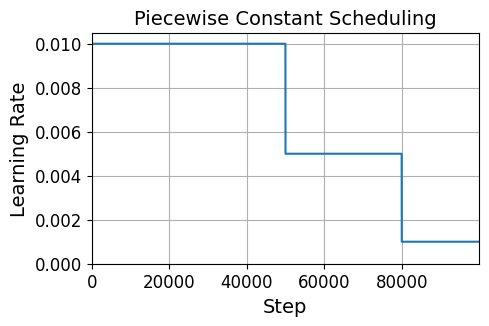

In [ ]:
boundaries = [50_000, 80_000]
values = [0.01, 0.005, 0.001]

steps = np.arange(100_000)

lrs = np.full(len(steps), values[0])
for boundary, value in zip(boundaries, values[1:]):
    lrs[boundary:] = value

plt.figure(figsize=(5, 3))
plt.plot(steps, lrs, "-")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [ ]:
# extra code – this cell demonstrates a more general way to define
#              piecewise constant scheduling.

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7598 - loss: 0.9777 - val_accuracy: 0.7622 - val_loss: 0.8007 - learning_rate: 0.0100
Epoch 2/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7917 - loss: 0.7024 - val_accuracy: 0.8008 - val_loss: 0.7968 - learning_rate: 0.0100
Epoch 3/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.7768 - loss: 0.7761 - val_accuracy: 0.7526 - val_loss: 0.8605 - learning_rate: 0.0100
Epoch 4/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.7543 - loss: 0.8158 - val_accuracy: 0.7912 - val_loss: 0.9032 - learning_rate: 0.0100
Epoch 5/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7068 - loss: 0.9669 - val_accuracy: 0.7388 - val_loss: 0.9396 - learning_rate: 0.0100
Epoch 6/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.7743 - loss: 0.6404 - val_accuracy: 0.8048 - val_loss: 0.6806 - learning_rate: 0.0050
Epoch 7/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.7

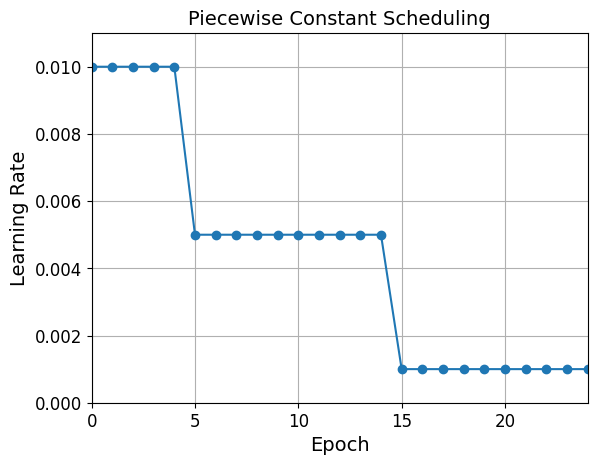

In [ ]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

**Performance Scheduling**

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7773 - loss: 0.7186 - val_accuracy: 0.8520 - val_loss: 0.4691 - learning_rate: 0.0200
Epoch 2/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8362 - loss: 0.5092 - val_accuracy: 0.8538 - val_loss: 0.5116 - learning_rate: 0.0200
Epoch 3/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8421 - loss: 0.5277 - val_accuracy: 0.8524 - val_loss: 0.5434 - learning_rate: 0.0200
Epoch 4/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8473 - loss: 0.5224 - val_accuracy: 0.8520 - val_loss: 0.5801 - learning_rate: 0.0200
Epoch 5/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8458 - loss: 0.5566 - val_accuracy: 0.8482 - val_loss: 0.6743 - learning_rate: 0.0200
Epoch 6/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8451 - loss: 0.5765 - val_accuracy: 0.8394 - val_loss: 0.7359 - learning_rate: 0.0200
Epoch 7/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8736 -

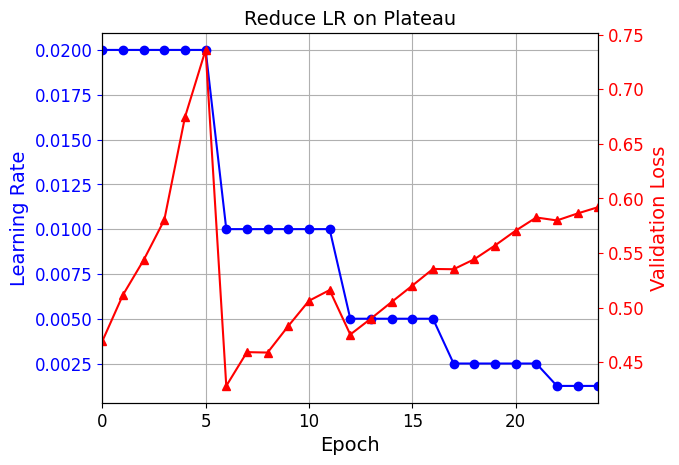

In [ ]:
plt.plot(history.epoch, history.history["learning_rate"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

**tf.keras schedulers**

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7924 - loss: 0.5998 - val_accuracy: 0.8554 - val_loss: 0.4083
Epoch 2/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8629 - loss: 0.3890 - val_accuracy: 0.8644 - val_loss: 0.3794
Epoch 3/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8760 - loss: 0.3526 - val_accuracy: 0.8724 - val_loss: 0.3642
Epoch 4/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8838 - loss: 0.3290 - val_accuracy: 0.8756 - val_loss: 0.3545
Epoch 5/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8904 - loss: 0.3115 - val_accuracy: 0.8770 - val_loss: 0.3477
Epoch 6/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8951 - loss: 0.2977 - val_accuracy: 0.8788 - val_loss: 0.3427
Epoch 7/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8992 - loss: 0.2865 - val_accuracy: 0.8812 - val_loss: 0.3390
Epoch 8/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9021 - loss: 0.277

In [ ]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

# Avoiding Overfitting Through Regularization

 **$l_1$ and $l_2$
 Regularization**

In [ ]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7981 - loss: 3.1806 - val_accuracy: 0.8432 - val_loss: 0.7011
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8230 - loss: 0.7262 - val_accuracy: 0.8448 - val_loss: 0.6816


In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7978 - loss: 3.2517 - val_accuracy: 0.8382 - val_loss: 0.7114
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.8221 - loss: 0.7307 - val_accuracy: 0.8424 - val_loss: 0.6864


**Dropout**

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7594 - loss: 0.7498 - val_accuracy: 0.8592 - val_loss: 0.3817
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8403 - loss: 0.4339 - val_accuracy: 0.8738 - val_loss: 0.3430


In [ ]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

**Max norm**

In [ ]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [ ]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8050 - loss: 0.5670 - val_accuracy: 0.8696 - val_loss: 0.3678
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8670 - loss: 0.3682 - val_accuracy: 0.8704 - val_loss: 0.3517
